# Training a ride duration prediction model

> El objetivo es entrenar un modelo de ML para predecir la duración de viajes en taxis

## Contexto de los datos

Los registros de viajes en taxi amarillo y verde incluyen campos que capturan fechas/horas de recogida y devolución, lugares de recogida y devolución, distancias de viaje, tarifas detalladas, tipos de tarifas, tipos de pago y recuentos de pasajeros informados por el conductor. Los datos utilizados en los conjuntos de datos adjuntos fueron recopilados y proporcionados a la Comisión de Taxis y Limusinas de la Ciudad de Nueva York (TLC) por proveedores de tecnología autorizados bajo los Programas de mejora de pasajeros de taxis y vehículos de librea (TPEP/LPEP). Los datos del viaje no fueron creados por la TLC y la TLC no garantiza la exactitud de estos datos.

### Fuente de los datos

Los datos de viajes de los taxis amarillos pueden ser descargados en `https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page`

In [97]:
import pandas as pd
# data viz
import matplotlib.pyplot as plt
import seaborn as sns
# para hacer One Hot Encoding
from sklearn.feature_extraction import DictVectorizer
# importar modelo de regresion lineal
from sklearn.linear_model import LinearRegression
# model evaluatrion
from sklearn.metrics import mean_squared_error

In [51]:
df = pd.read_parquet('../data/green_tripdata_2024-01.parquet')
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


### Descripción de las variables

* **VendorID** : ID el proveedor de TPEP que proporcionó el registro: 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.

* **lpep_pickup_datetime** : La fecha y hora en que se activó el medidor.

* **lpep_dropoff_datetime** : La fecha y hora en que se desconectó el medidor.

* **store_and_fwd_flag**: Indicadora de si el registro de viaje se mantuvo en la memoria del vehículo antes de enviarlo al proveedor, también conocido como "almacenar y reenviar", porque el vehículo no tenía una conexión con el servidor.

* **trip_type** : Indicadora de si el viaje fue por parada callejera o un despacho que se asigna automáticamente según la tarifa medida en uso (dispatch), pero que el conductor puede modificar.
`` 
1 = Parada callejera \\
2 = Dispatch
``

Al _dataset_ base, le agregamos la duración de los viajes, calculando la diferencia entre `lpep_pickup_datetime` y `lpep_dropoff_datetime`

### EDA

In [52]:
# Converting to datetime object the start and end of trips
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [53]:
# create target variable
df['trip_duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
# compute the minutes of durstion of each trip
df['trip_duration'] = df['trip_duration'].apply(lambda td: td.total_seconds()/60)

Hay dos tipos de viajes. ¿cuántos hay de cada tipo?

In [54]:
(
    df
    .groupby('trip_type', as_index = False)[['VendorID']]
    .count()
    .rename(columns = {"VendorID" : "total"})
)

,trip_type,total
0,1.0,51397
1,2.0,1736


In [55]:
df.trip_duration.describe(percentiles = [0.05, 0.98, 0.99])

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
5%           2.883333
50%         11.400000
98%         46.816667
99%         59.825000
max       1438.983333
Name: trip_duration, dtype: float64

Como podemos observar la maoría de los viajes duran entre 3 y 60 minutos. Existen registros de viajes "atípicos", cuya duración es de 0 minutos o 1438 minutos, es decir 60 días continuos. Para éste último registro, se tiene la hipótesis de que fue un viaje para el cual el conductor omitió apagar el temporizador del último viaje.

No consideraremos registros de viajes con duración atípica, para no _contaminar_ el conjunto de datos

¿cuánto dura en promedio el viaje por cada tipo de viaje?

## Tipo 1: Parada callejera

In [56]:
df_ = df[df.trip_type == 1]
mean_duration_t1 = (
    df_[(df_.trip_duration >= 1) & (df_.trip_duration <= 60)]
    .trip_duration
    .mean()
)
print(f"Duración promedio de viajes de parada callejera: {mean_duration_t1} minutos")

Duración promedio de viajes de parada callejera: 13.3219339685324 minutos


## Tipo 2: Dispatch

In [57]:
df__ = df[df.trip_type == 2]
mean_duration_t2 = (
    df__[(df__.trip_duration >= 1) & (df__.trip_duration <= 60)]
    .trip_duration
    .mean()
)
print(f"Duración promedio de viajes dispatch: {mean_duration_t2} minutos")

Duración promedio de viajes dispatch: 16.27719298245614 minutos


In [58]:
df[['trip_duration']].head()

,trip_duration
0,11.500000
1,20.866667
2,19.033333
3,11.866667
4,10.983333


## Filtering the dataset

Aunque en prinicpio no parece haber una diferencia significativa en la duración de los viajes por tipo, en esta iteración del ejercicio, nos enfocaremos solo en viajes de tipo `Dispatch`

In [59]:
df = df[df.trip_type == 2]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
36,2,2024-01-01 00:15:43,2024-01-01 00:15:51,N,5.0,61,61,2.0,0.00,22.00,...,0.0,0.0,0.0,NaN,1.0,23.00,2.0,2.0,0.0,0.133333
45,2,2024-01-01 00:34:56,2024-01-01 00:34:57,N,5.0,66,264,2.0,0.00,50.00,...,0.0,10.2,0.0,NaN,1.0,61.20,1.0,2.0,0.0,0.016667
56,2,2024-01-01 00:52:23,2024-01-01 01:07:39,N,5.0,74,127,1.0,5.76,25.55,...,0.0,0.0,0.0,NaN,1.0,26.55,2.0,2.0,0.0,15.266667
58,2,2024-01-01 00:55:10,2024-01-01 01:22:19,N,5.0,189,91,2.0,5.04,30.99,...,0.0,6.4,0.0,NaN,1.0,38.39,1.0,2.0,0.0,27.150000
59,2,2024-01-01 00:56:37,2024-01-01 00:56:42,N,5.0,173,173,1.0,0.00,15.00,...,0.0,0.0,0.0,NaN,1.0,16.00,1.0,2.0,0.0,0.083333


### Distribución de la variable objetivo

In [60]:
df.trip_duration.describe(percentiles = [0.05, 0.98, 0.99])

count    1736.000000
mean       13.225931
std        73.049482
min         0.000000
5%          0.033333
50%         1.708333
98%        52.145000
99%        65.337500
max      1438.983333
Name: trip_duration, dtype: float64

In [61]:
# consideraremos viajes solo cuya duracion haya estado entre 1 y 60 minutos
df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
56,2,2024-01-01 00:52:23,2024-01-01 01:07:39,N,5.0,74,127,1.0,5.76,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,15.266667
58,2,2024-01-01 00:55:10,2024-01-01 01:22:19,N,5.0,189,91,2.0,5.04,30.99,...,0.0,6.40,0.00,NaN,1.0,38.39,1.0,2.0,0.00,27.150000
63,2,2024-01-01 00:30:12,2024-01-01 01:05:01,N,5.0,66,237,1.0,7.38,50.00,...,0.0,10.75,0.00,NaN,1.0,64.50,1.0,2.0,2.75,34.816667
64,2,2024-01-01 00:59:24,2024-01-01 01:01:19,N,5.0,181,181,4.0,0.00,130.00,...,0.0,0.00,0.00,NaN,1.0,131.00,1.0,2.0,0.00,1.916667
75,2,2024-01-01 01:56:54,2024-01-01 02:14:31,N,5.0,66,170,1.0,6.18,50.05,...,0.0,10.76,0.00,NaN,1.0,64.56,1.0,2.0,2.75,17.616667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53050,2,2024-01-31 21:58:02,2024-01-31 22:04:22,N,5.0,42,41,1.0,1.06,10.00,...,0.0,0.00,0.00,NaN,1.0,11.00,2.0,2.0,0.00,6.333333
53099,2,2024-01-31 22:10:36,2024-01-31 22:16:46,N,5.0,42,74,1.0,1.03,8.00,...,0.0,0.00,0.00,NaN,1.0,9.00,2.0,2.0,0.00,6.166667
53110,2,2024-01-31 23:19:51,2024-01-31 23:52:04,N,5.0,25,162,2.0,8.32,40.00,...,0.0,2.00,6.94,NaN,1.0,52.69,1.0,2.0,2.75,32.216667
53123,2,2024-01-31 23:57:29,2024-02-01 00:24:07,N,5.0,181,100,2.0,6.16,60.00,...,0.0,12.75,0.00,NaN,1.0,76.50,1.0,2.0,2.75,26.633333


## Feature selection

Consideraremos como predictores las siguientes variables ñlas cuales pueden ser determinantes para la duración del viaje

In [63]:
# Pick up location ID and drop off location ID can be useful for predict the duration
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

Para las variables categóricas, implementaremos **OE** usando `DictVectorizer` el cual convierte todo lo que no sea un número a variable categórica. Por lo tanto, para cada valor que toma `DOLocation`y `PULocation` tendremos una variable

## Preprocessing

In [64]:
df[categorical] = df[categorical].astype(str)
# convertir cada fila del df principal a una lista de diccionarios
# cada uno de los cuales esta conformado por los valores de un registro
train_dicts = df[categorical + numerical].to_dict(orient = 'records')

In [68]:
# One Hot encoding
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

<893x280 sparse matrix of type '<class 'numpy.float64'>'
	with 2679 stored elements in Compressed Sparse Row format>

In [81]:
target = 'trip_duration'
y_train = df[target].values


## Train Linear Regression Model

In [84]:
lr = LinearRegression()
# entrenamiento del modelo
lr.fit(X_train, y_train)

LinearRegression()

Aunque la evaluación del modelo no debe hacerse evaluando dentro del conjunto de entrenamiento, **nos puede dar una idea de _overfitting__ o bien de_underfitting_**

In [91]:
y_pred_in_sample = lr.predict(X_train)

## Visualizing the dist of the actual and predicted values

/tmp/ipykernel_18365/2050741008.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_in_sample, label = 'prediction')
/tmp/ipykernel_18365/2050741008.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = 'actual')


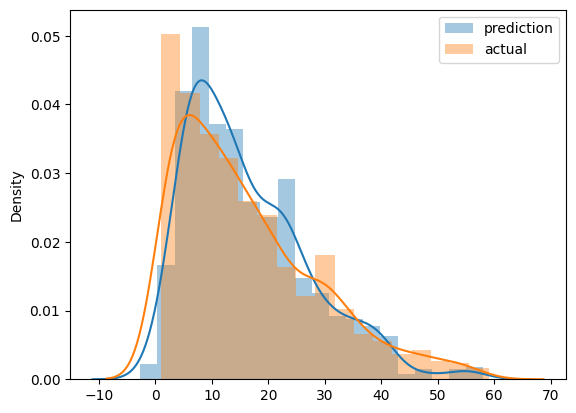

In [102]:
sns.distplot(y_pred_in_sample, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [104]:
mean_squared_error(y_train, y_pred=y_pred_in_sample, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.20494543905279

Por lo tanto, en promedio nuestro modelo base se equivoca por 6 minutos. En prinicipio no podemos afirmar si este resultado es bueno o malo, aunque por supuesto podríamos intentar mejorarlo